In [1]:
! pip install torchsummary

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import argparse,copy,h5py, os,sys,time,socket
import tensorflow as tf

# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.autograd.variable import Variable

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from matplotlib import ticker,colors

In [3]:
# define transformations for train
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define transformations for test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define training dataloader
def get_training_dataloader(train_transform, batch_size=128, num_workers=0, shuffle=True):
    """ return training dataloader
    Args:
        train_transform: transfroms for train dataset
        path: path to cifar100 training python dataset
        batch_size: dataloader batchsize
        num_workers: dataloader num_works
        shuffle: whether to shuffle 
    Returns: train_data_loader:torch dataloader object
    """

    transform_train = train_transform
    cifar10_training = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform_train)
    cifar10_training_loader = DataLoader(
        cifar10_training, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar10_training_loader

# define test dataloader
def get_testing_dataloader(test_transform, batch_size=128, num_workers=0, shuffle=True):
    """ return training dataloader
    Args:
        test_transform: transforms for test dataset
        path: path to cifar100 test python dataset
        batch_size: dataloader batchsize
        num_workers: dataloader num_works
        shuffle: whether to shuffle 
    Returns: cifar100_test_loader:torch dataloader object
    """

    transform_test = test_transform
    cifar10_test = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform_test)
    cifar10_test_loader = DataLoader(
        cifar10_test, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar10_test_loader

In [4]:
# implement mish activation function
def f_mish(input):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    '''
    return input * torch.tanh(F.softplus(input))

# implement class wrapper for mish activation function
class mish(nn.Module):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = mish()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return f_mish(input)

In [5]:
# implement swish activation function
def f_swish(input):
    '''
    Applies the swish function element-wise:
    swish(x) = x * sigmoid(x)
    '''
    return input * torch.sigmoid(input)

# implement class wrapper for swish activation function
class swish(nn.Module):
    '''
    Applies the swish function element-wise:
    swish(x) = x * sigmoid(x)

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = swish()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return f_swish(input)

In [6]:
# see https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
# see https://discuss.pytorch.org/t/why-input-is-tensor-in-the-forward-function-when-extending-torch-autograd/9039
class ShakeShake(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input1, input2, alpha, beta=None):
        ctx.save_for_backward(input1, input2, alpha, beta)
        out = alpha * input1 + (1 - alpha) * input2
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input1, input2, alpha, beta = ctx.saved_tensors
        grad_input1 = beta * grad_output
        grad_input2 = (1 - beta) * grad_output
        return grad_input1, grad_input2, None, None


class SkippingBranch(nn.Module):
    def __init__(self, inplanes, stride=2):
        super(SkippingBranch, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, inplanes, kernel_size=1, stride=1, 
                              padding=0, bias=False)
        self.conv2 = nn.Conv2d(inplanes, inplanes, kernel_size=1, stride=1, 
                              padding=0, bias=False)
        self.avg_pool = nn.AvgPool2d(kernel_size=1, stride=stride, padding=0)    

    def forward(self, x):
        out1 = self.conv1(self.avg_pool(x))
        shift_x = x[:, :, 1:, 1:]
        shift_x= F.pad(shift_x, (0, 1, 0, 1))
        out2 = self.conv2(self.avg_pool(shift_x))
        out = torch.cat([out1, out2], dim=1)
        return out


class ResidualBranch(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super(ResidualBranch, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, 
                               stride=stride, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, 
                               stride=1, padding=1, bias=False) 
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = self.bn1(self.conv1(F.relu(x, inplace=False)))
        out = self.bn2(self.conv2(F.relu(out, inplace=False)))
        return out


class ShakeBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super(ShakeBlock, self).__init__()
        self.residual_branch1 = ResidualBranch(inplanes, planes, stride)
        self.residual_branch2 = ResidualBranch(inplanes, planes, stride)

        if inplanes != planes:
            self.skipping_branch = SkippingBranch(inplanes, stride)
        else:
            self.skipping_branch = nn.Sequential()

        self.shake_shake = ShakeShake.apply

    def forward(self, x):
        residual = x
        out1 = self.residual_branch1(x)
        out2 = self.residual_branch2(x)
        
        batch_size = out1.size(0)
        if self.training:        
            alpha = torch.rand(batch_size).to(device)
            beta = torch.rand(batch_size).to(device)
            beta = beta.view(batch_size, 1, 1, 1)
            alpha = alpha.view(batch_size, 1, 1, 1)
            out = self.shake_shake(out1, out2, alpha, beta)
        else:
            alpha = torch.Tensor([0.5]).to(device)
            out = self.shake_shake(out1, out2, alpha)

        skip = self.skipping_branch(residual)
        return out + skip


class ShakeResNet(nn.Module):
    def __init__(self, block, num_classes=10, activation = 'relu'):
        super(ShakeResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        if (activation == 'relu'):
            self.relu = nn.ReLU(inplace=True)
        if (activation == 'swish'):
            self.relu = swish()
        if (activation == 'mish'):
            self.relu = mish()

        self.stage1 = self._make_stage(block, 32, 4, stride=1)
        self.stage2 = self._make_stage(block, 64, 4, stride=2) 
        self.stage3 = self._make_stage(block, 128, 4, stride=2)  
        self.avg_pool = nn.AvgPool2d(8, stride=1)
        self.fc_out = nn.Linear(128, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', 
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_stage(self, block, planes, blocks, stride=1):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)
        return x


def shake_shake(activation = 'relu', **kwargs):
    model = ShakeResNet(ShakeBlock, activation = activation, **kwargs) 
    return model

In [7]:
trainloader = get_training_dataloader(train_transform)
testloader = get_testing_dataloader(test_transform)

0it [00:00, ?it/s]

170500096it [00:06, 28180487.19it/s]                               


Files already downloaded and verified


In [8]:
epochs = 30
batch_size = 128
learning_rate = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
model_relu = shake_shake(activation = 'relu') # Shake-shake ReLU
model_swish = shake_shake(activation = 'swish') # Shake-shake Swish
model_mish = shake_shake(activation = 'mish') # Shake-shake Mish

In [10]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer_relu = Adam(model_relu.parameters(), lr=learning_rate)
optimizer_swish = Adam(model_swish.parameters(), lr=learning_rate)
optimizer_mish = Adam(model_mish.parameters(), lr=learning_rate)

In [11]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy']) 

In [12]:
def train(model, device, epochs, trainloader, testloader, criterion, optimizer, train_stats):
    #train the model
    model.to(device)

    steps = 0
    running_loss = 0
    for epoch in range(epochs):

        since = time.time()

        train_accuracy = 0
        top3_train_accuracy = 0 
        for inputs, labels in trainloader:
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # calculate train top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # Calculate train top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

        time_elapsed = time.time() - since

        test_loss = 0
        test_accuracy = 0
        top3_test_accuracy = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                test_loss += batch_loss.item()

                # Calculate test top-1 accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                # Calculate test top-3 accuracy
                np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
                target_numpy = labels.cpu().numpy()
                top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Time per epoch: {time_elapsed:.4f}.. "
              f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
              f"Train loss: {running_loss/len(trainloader):.4f}.. "
              f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
              f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
              f"Test loss: {test_loss/len(testloader):.4f}.. "
              f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
              f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}")

        train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader), 'Train accuracy': train_accuracy/len(trainloader), 'Train top-3 accuracy':top3_train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader), 'Test accuracy': test_accuracy/len(testloader), 'Test top-3 accuracy':top3_test_accuracy/len(testloader)}, ignore_index=True)

        running_loss = 0
        model.train()

    return model, train_stats

In [13]:
#  Get the weights - after training
def get_weights(net):
    return [p.data for p in net.parameters()]

def get_random_weights(weights):
    return [torch.randn(w.size()) for w in weights]

def normalize_direction(direction, weights,norm='layer'):
    if norm == 'filter':
        # Rescale the filters (weights in group) in 'direction' so that each filter has the same norm as its corresponding filter in 'weights'.
        for d, w in zip(direction, weights): 
            # the direction channel gets norm via the channel
            d.mul_(w.norm()/(d.norm() + 1e-10))

    elif norm == 'layer':
        # Rescale the layer variables in the direction so that each layer has the same norm as the layer variables in weights.
        direction.mul_(weights.norm()/direction.norm())

    elif norm == 'weight':
        # Rescale the entries in the direction so that each entry has the same scale as the corresponding weight.
        direction.mul_(weights.cpu())

    elif norm == 'dfilter':
        # Rescale the entries in the direction so that each filter direction has the unit norm.
        for d in direction: 
            d.div_(d.norm() + 1e-10)

    elif norm == 'dlayer':
        # Rescale the entries in the direction so that each layer direction has the unit norm.
        direction.div_(direction.norm())

In [14]:
def get_weights_mod(net):
    weight = get_weights(net)
    temp_layer  = 0
    for x in weight: 
        temp_layer = temp_layer + 1
        print(str(temp_layer) + " layer " + str(x.shape))

In [15]:
weight_relu = get_weights(model_relu)

In [16]:
weight_swish = get_weights(model_swish)

In [17]:
weight_mish = get_weights(model_mish)

In [18]:
model_relu, train_stats_relu = train(model_relu, device, epochs, trainloader, testloader, criterion, optimizer_relu, train_stats)
model_swish, train_stats_swish = train(model_swish, device, epochs, trainloader, testloader, criterion, optimizer_swish, train_stats)
model_mish, train_stats_mish = train(model_mish, device, epochs, trainloader, testloader, criterion, optimizer_mish, train_stats)

Epoch 1/30.. Time per epoch: 55.3393.. Average time per step: 0.1415.. Train loss: 1.6384.. Train accuracy: 0.4045.. Top-3 train accuracy: 0.7454.. Test loss: 1.4047.. Test accuracy: 0.4949.. Top-3 test accuracy: 0.8234
Epoch 2/30.. Time per epoch: 54.2400.. Average time per step: 0.1387.. Train loss: 1.2978.. Train accuracy: 0.5326.. Top-3 train accuracy: 0.8421.. Test loss: 1.1112.. Test accuracy: 0.6082.. Top-3 test accuracy: 0.8804
Epoch 3/30.. Time per epoch: 54.3635.. Average time per step: 0.1390.. Train loss: 1.1488.. Train accuracy: 0.5879.. Top-3 train accuracy: 0.8735.. Test loss: 0.9443.. Test accuracy: 0.6657.. Top-3 test accuracy: 0.9128
Epoch 4/30.. Time per epoch: 54.0515.. Average time per step: 0.1382.. Train loss: 1.0395.. Train accuracy: 0.6309.. Top-3 train accuracy: 0.8954.. Test loss: 0.8540.. Test accuracy: 0.7016.. Top-3 test accuracy: 0.9250
Epoch 5/30.. Time per epoch: 54.3063.. Average time per step: 0.1389.. Train loss: 0.9644.. Train accuracy: 0.6583.. Top

## ReLU

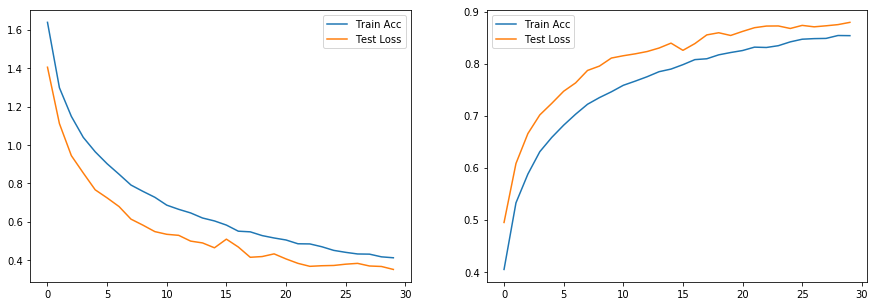

In [19]:
# get the converged weights and plot them 
converged_weights_relu = get_weights(model_relu)
plt.figure(figsize=(15,5))
plt.subplot(121); 
plt.plot(train_stats_relu['Train loss'].values,label='Train Acc')
plt.plot(train_stats_relu['Test loss'].values,label='Test Loss')
plt.legend()

plt.subplot(122); 
plt.plot(train_stats_relu['Train accuracy'].values,label='Train Acc')
plt.plot(train_stats_relu['Test accuracy'].values,label='Test Loss')

plt.legend()
plt.show()

## Swish

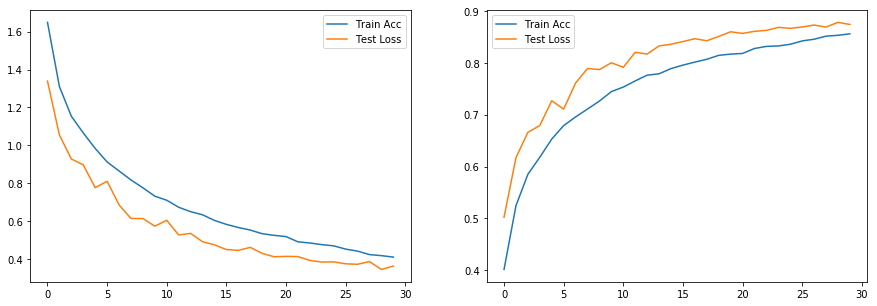

In [20]:
# get the converged weights and plot them 
converged_weights_swish = get_weights(model_swish)
plt.figure(figsize=(15,5))
plt.subplot(121); 
plt.plot(train_stats_swish['Train loss'].values,label='Train Acc')
plt.plot(train_stats_swish['Test loss'].values,label='Test Loss')
plt.legend()

plt.subplot(122); 
plt.plot(train_stats_swish['Train accuracy'].values,label='Train Acc')
plt.plot(train_stats_swish['Test accuracy'].values,label='Test Loss')

plt.legend()
plt.show()

## Mish

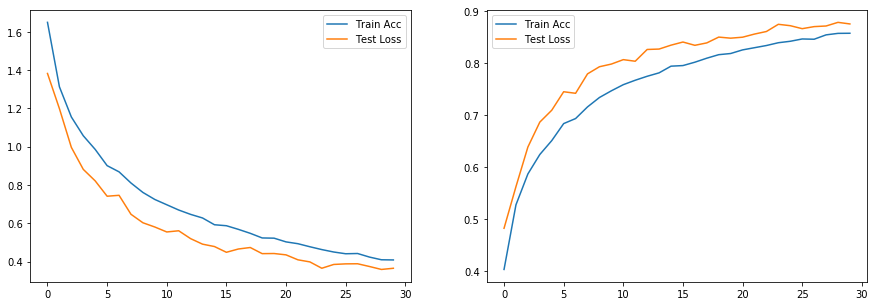

In [21]:
# get the converged weights and plot them 
converged_weights_mish = get_weights(model_mish)
plt.figure(figsize=(15,5))
plt.subplot(121); 
plt.plot(train_stats_mish['Train loss'].values,label='Train Acc')
plt.plot(train_stats_mish['Test loss'].values,label='Test Loss')
plt.legend()

plt.subplot(122); 
plt.plot(train_stats_mish['Train accuracy'].values,label='Train Acc')
plt.plot(train_stats_mish['Test accuracy'].values,label='Test Loss')

plt.legend()
plt.show()

In [22]:
# create help functions
def viz_histogram_weights(converged_weights, direction1,direction2,title="None"):
    plt.figure(figsize=(55,55//9))
    plt.suptitle(title, fontsize=20, y=1.15)
    for layer_index in range(len(converged_weights)):
        plt.subplot(1,9,layer_index+1)
        plt.title("Layer : " + str(layer_index))
        plt.hist(converged_weights[layer_index].cpu().numpy().ravel(),50,alpha=0.6,label='Weight')
        plt.hist(direction1[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 1')
        plt.hist(direction2[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 2')
        plt.yticks([])
        plt.legend()
    plt.show()
def create_viz(loss_list,acc_list,title="none"):
    
    # plot the loss functions
    plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.title("Original Contour")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    plt.clabel(CS, inline=1, fontsize=8)

    plt.subplot(132)
    plt.title("Original Contour with Color")
    plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    CS = plt.contourf(xcoord_mesh, ycoord_mesh, loss_list, 10, zorder=1, cmap='terrain', linestyles='--')   
    plt.clabel(CS, fontsize=12,inline=0,fmt = '%2.1f')
    plt.colorbar(CS)

    plt.subplot(133)
    plt.title("Log Scale")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, np.log(loss_list+1e-8),10,zorder=1, cmap='terrain', linestyles='--'); 
    plt.clabel(CS, fontsize=8,inline=1)

    plt.savefig(title)
    plt.show()
    
    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(loss_list.max()-loss_list.min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+loss_list.min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=loss_list,colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(np.log(loss_list).max()-np.log(loss_list).min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+np.log(loss_list).min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(loss_list),colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Log Scale Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

In [23]:
# create the coordinates
numebr_of_points = 9 ; small_range = -1.0 ; large_range =  1.0

xcoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 
ycoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 

xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
inds = np.array(range(numebr_of_points**2))
s1   = xcoord_mesh.ravel()[inds]
s2   = ycoord_mesh.ravel()[inds]
coordinate = np.c_[s1,s2]
print('From ',small_range,' to ',large_range,' with ',numebr_of_points,' total number of coordinate: ', numebr_of_points**2)

From  -1.0  to  1.0  with  9  total number of coordinate:  81


In [24]:
copy_of_the_weights_relu = [w.clone() for w in converged_weights_relu]
copy_of_the_weights_swish = [w.clone() for w in converged_weights_swish]
copy_of_the_weights_mish = [w.clone() for w in converged_weights_mish]
sess = tf.InteractiveSession()

## ReLU

In [25]:
direction1 = []
dimension  = (0,2)
for w in copy_of_the_weights_relu:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape) 
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))
        direction1.append(random_vector)
    else:
        direction1.append(torch.zeros_like(w))

In [26]:
direction2 = []
dimension  = (1,3)
for w in copy_of_the_weights_relu:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape) 
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))
        direction2.append(random_vector)
    else:
        direction2.append(torch.zeros_like(w))

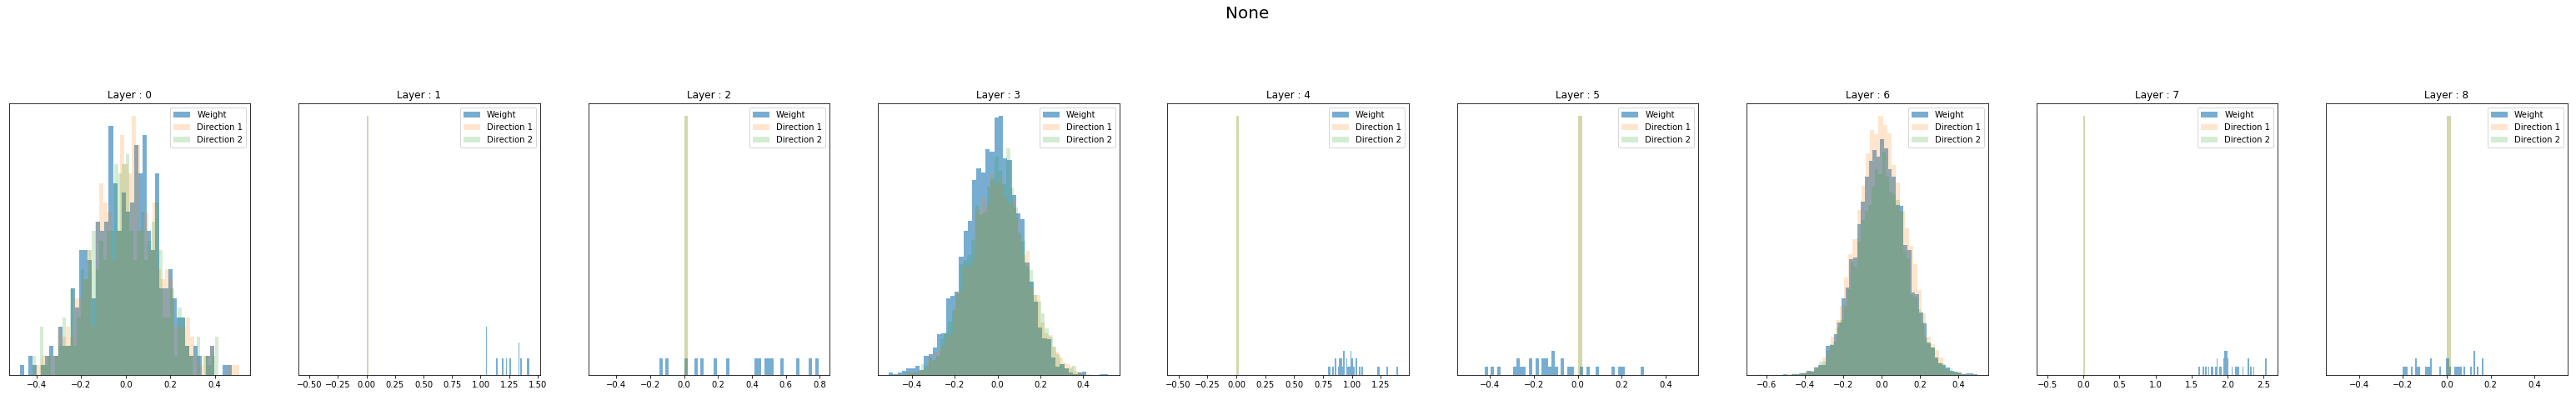

In [27]:
viz_histogram_weights(copy_of_the_weights_relu[:9],direction1,direction2) # plot for the 1st 9 layers

In [28]:
# Set up the direction 
current_direction1 = direction1
current_direction2 = direction2
current_loader     = trainloader

In [29]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(current_direction1, current_direction2)]
    for (p, w, d) in zip(model_relu.parameters(), weight_relu, changes):
        w = w.type(torch.FloatTensor)
        w = w.cuda()
        d = d.type(torch.FloatTensor)
        d = d.cuda()
        p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = model_relu(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 9.872159090909092	Loss: 6.711
count: 2	Coord: [-0.5 -1. ]		Acc: 9.446022727272727	Loss: 5.263
count: 4	Coord: [ 0. -1.]		Acc: 10.724431818181818	Loss: 4.303
count: 6	Coord: [ 0.5 -1. ]		Acc: 16.12215909090909	Loss: 4.25
count: 8	Coord: [ 1. -1.]		Acc: 10.9375	Loss: 5.334
count: 10	Coord: [-0.75 -0.75]		Acc: 9.161931818181818	Loss: 5.298
count: 12	Coord: [-0.25 -0.75]		Acc: 9.872159090909092	Loss: 3.86
count: 14	Coord: [ 0.25 -0.75]		Acc: 14.701704545454545	Loss: 3.462
count: 16	Coord: [ 0.75 -0.75]		Acc: 10.795454545454545	Loss: 3.752
count: 18	Coord: [-1.  -0.5]		Acc: 9.090909090909092	Loss: 5.157
count: 20	Coord: [-0.5 -0.5]		Acc: 9.232954545454545	Loss: 3.796
count: 22	Coord: [ 0.  -0.5]		Acc: 10.511363636363637	Loss: 3.03
count: 24	Coord: [ 0.5 -0.5]		Acc: 11.647727272727273	Loss: 3.048
count: 26	Coord: [ 1.  -0.5]		Acc: 10.653409090909092	Loss: 4.478
count: 28	Coord: [-0.75 -0.25]		Acc: 8.948863636363637	Loss: 3.859
count: 30	Coord: [-0.25 -0.25]		A

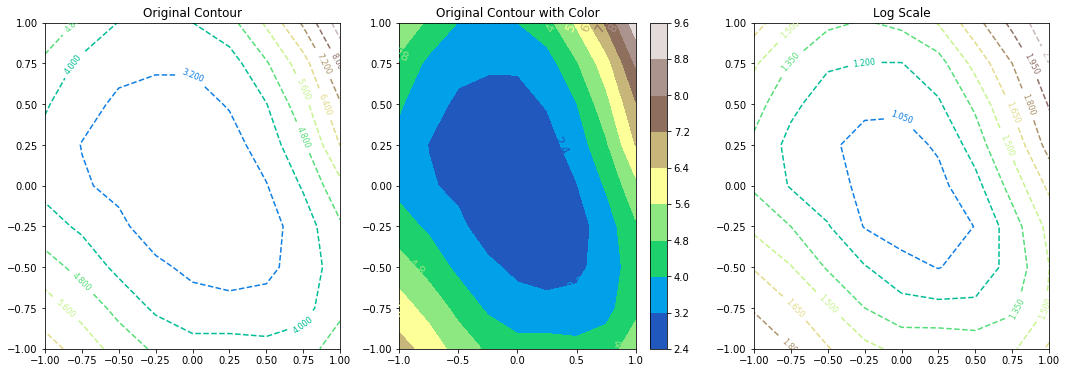

In [30]:
create_viz(loss_list,acc_list)

## Swish

In [31]:
direction1 = []
dimension  = (0,2)
for w in copy_of_the_weights_swish:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape) 
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))
        direction1.append(random_vector)
    else:
        direction1.append(torch.zeros_like(w))

In [32]:
direction2 = []
dimension  = (1,3)
for w in copy_of_the_weights_swish:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape) 
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))
        direction2.append(random_vector)
    else:
        direction2.append(torch.zeros_like(w))

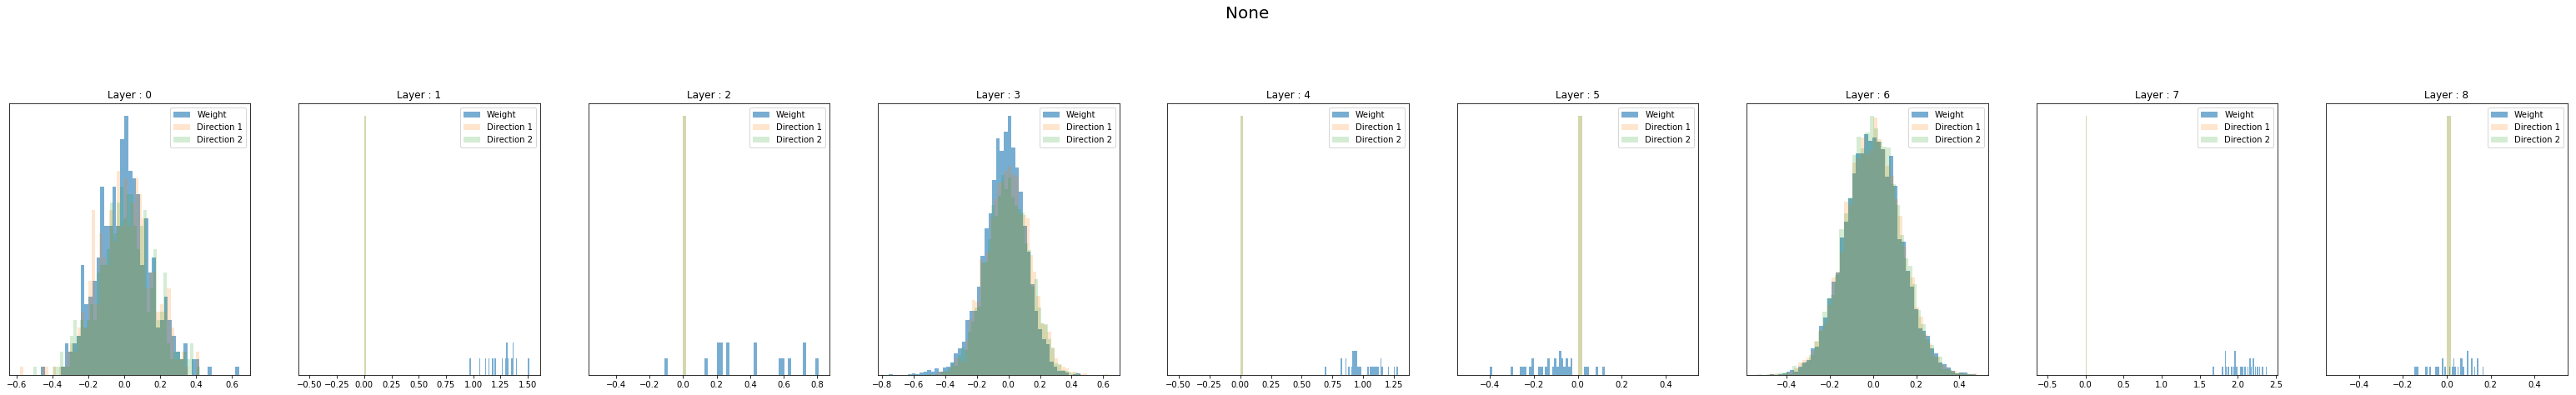

In [33]:
viz_histogram_weights(copy_of_the_weights_swish[:9],direction1,direction2) # plot for the 1st 9 layers

In [34]:
# Set up the direction 
current_direction1 = direction1
current_direction2 = direction2
current_loader     = trainloader

In [35]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(current_direction1, current_direction2)]
    for (p, w, d) in zip(model_swish.parameters(), weight_relu, changes):
        w = w.type(torch.FloatTensor)
        w = w.cuda()
        d = d.type(torch.FloatTensor)
        d = d.cuda()
        p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = model_swish(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 7.599431818181818	Loss: 5.457
count: 2	Coord: [-0.5 -1. ]		Acc: 9.588068181818182	Loss: 4.11
count: 4	Coord: [ 0. -1.]		Acc: 10.227272727272727	Loss: 3.473
count: 6	Coord: [ 0.5 -1. ]		Acc: 10.9375	Loss: 3.605
count: 8	Coord: [ 1. -1.]		Acc: 9.303977272727273	Loss: 4.707
count: 10	Coord: [-0.75 -0.75]		Acc: 8.380681818181818	Loss: 3.897
count: 12	Coord: [-0.25 -0.75]		Acc: 7.954545454545454	Loss: 3.254
count: 14	Coord: [ 0.25 -0.75]		Acc: 11.079545454545455	Loss: 2.915
count: 16	Coord: [ 0.75 -0.75]		Acc: 11.71875	Loss: 3.308
count: 18	Coord: [-1.  -0.5]		Acc: 8.877840909090908	Loss: 3.742
count: 20	Coord: [-0.5 -0.5]		Acc: 8.522727272727273	Loss: 3.045
count: 22	Coord: [ 0.  -0.5]		Acc: 8.664772727272727	Loss: 2.713
count: 24	Coord: [ 0.5 -0.5]		Acc: 10.795454545454545	Loss: 2.779
count: 26	Coord: [ 1.  -0.5]		Acc: 8.806818181818182	Loss: 3.709
count: 28	Coord: [-0.75 -0.25]		Acc: 9.375	Loss: 3.021
count: 30	Coord: [-0.25 -0.25]		Acc: 10.085227272727273

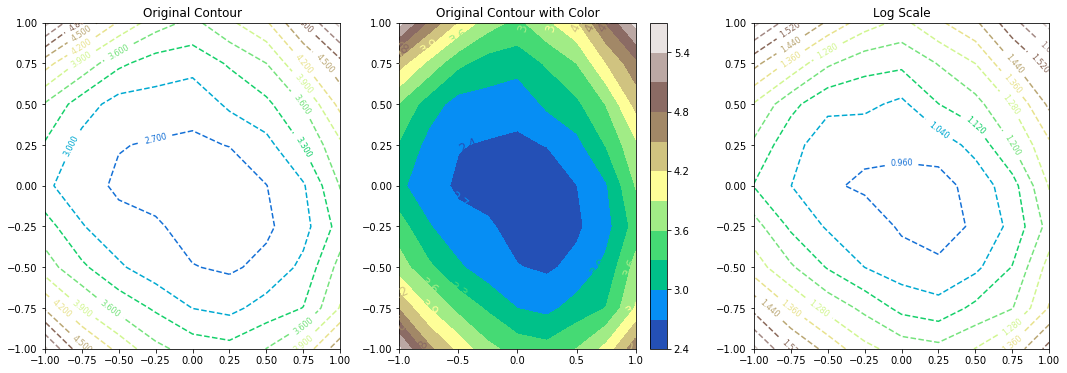

In [36]:
create_viz(loss_list,acc_list)

## Mish

In [37]:
direction1 = []
dimension  = (0,2)
for w in copy_of_the_weights_mish:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape) 
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))
        direction1.append(random_vector)
    else:
        direction1.append(torch.zeros_like(w))

In [38]:
direction2 = []
dimension  = (1,3)
for w in copy_of_the_weights_mish:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape) 
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))
        direction2.append(random_vector)
    else:
        direction2.append(torch.zeros_like(w))

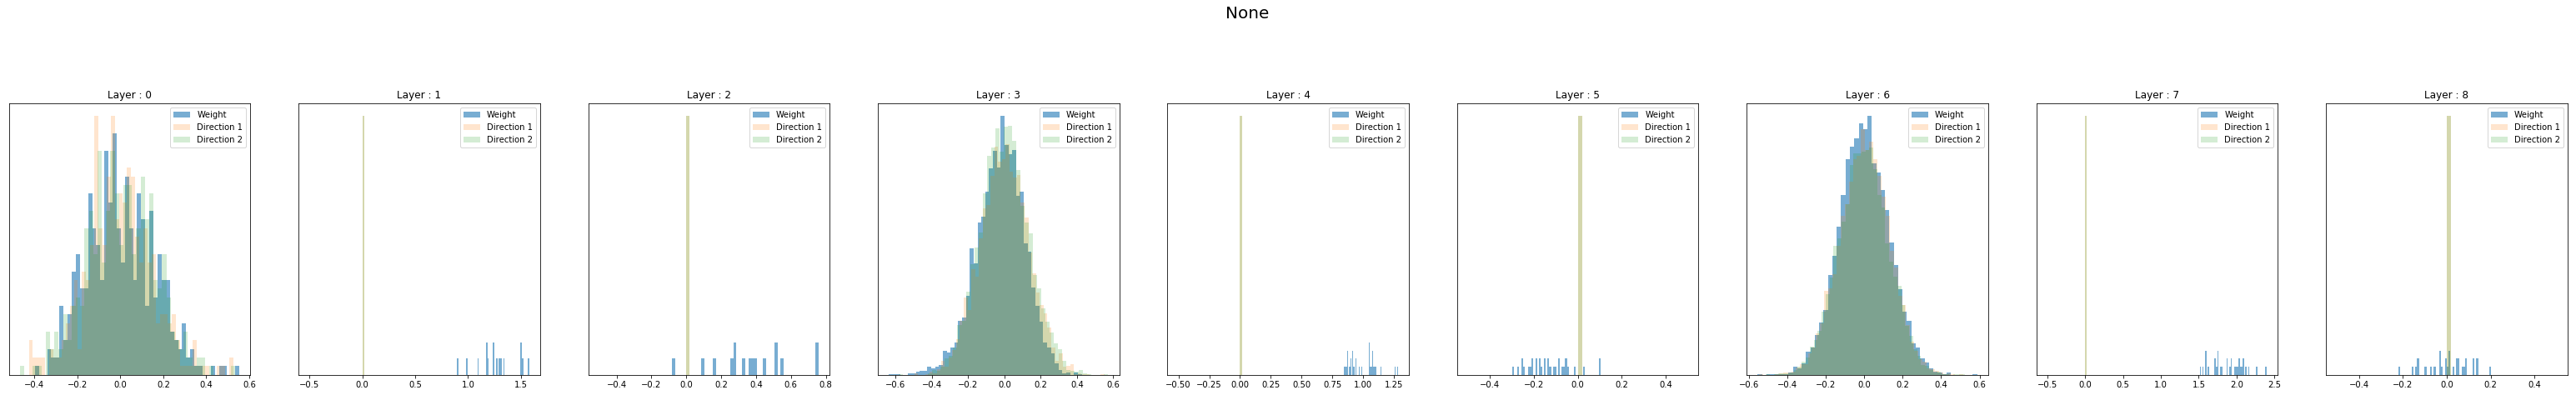

In [39]:
viz_histogram_weights(copy_of_the_weights_mish[:9],direction1,direction2) # plot for the 1st 9 layers

In [40]:
# Set up the direction 
current_direction1 = direction1
current_direction2 = direction2
current_loader     = trainloader

In [41]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(current_direction1, current_direction2)]
    for (p, w, d) in zip(model_mish.parameters(), weight_mish, changes):
        w = w.type(torch.FloatTensor)
        w = w.cuda()
        d = d.type(torch.FloatTensor)
        d = d.cuda()
        p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = model_mish(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 11.221590909090908	Loss: 5.816
count: 2	Coord: [-0.5 -1. ]		Acc: 10.653409090909092	Loss: 4.252
count: 4	Coord: [ 0. -1.]		Acc: 11.931818181818182	Loss: 3.897
count: 6	Coord: [ 0.5 -1. ]		Acc: 11.079545454545455	Loss: 5.111
count: 8	Coord: [ 1. -1.]		Acc: 10.866477272727273	Loss: 7.398
count: 10	Coord: [-0.75 -0.75]		Acc: 10.227272727272727	Loss: 4.128
count: 12	Coord: [-0.25 -0.75]		Acc: 10.582386363636363	Loss: 3.305
count: 14	Coord: [ 0.25 -0.75]		Acc: 10.724431818181818	Loss: 3.46
count: 16	Coord: [ 0.75 -0.75]		Acc: 10.085227272727273	Loss: 4.534
count: 18	Coord: [-1.  -0.5]		Acc: 10.582386363636363	Loss: 4.591
count: 20	Coord: [-0.5 -0.5]		Acc: 9.090909090909092	Loss: 3.169
count: 22	Coord: [ 0.  -0.5]		Acc: 10.227272727272727	Loss: 2.787
count: 24	Coord: [ 0.5 -0.5]		Acc: 11.079545454545455	Loss: 3.233
count: 26	Coord: [ 1.  -0.5]		Acc: 9.588068181818182	Loss: 4.997
count: 28	Coord: [-0.75 -0.25]		Acc: 10.511363636363637	Loss: 3.692
count: 30	Coor

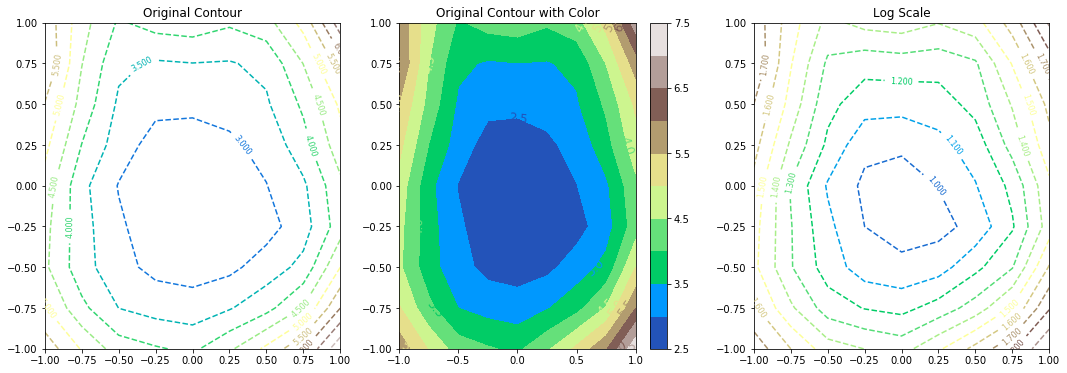

In [42]:
create_viz(loss_list,acc_list)